In [2]:
import torch
import numpy as np
import pandas as pd
from torch import nn 
import torch.nn.functional as F 
from collections import OrderedDict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import sklearn
import scipy
from sklearn.cluster import SpectralClustering

In [64]:
import numpy as np
import argparse
from tqdm import tqdm 
from sklearn.datasets import load_wine,load_boston
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity,rbf_kernel
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn,optim
import torch

In [10]:

def wine_data():
    data = load_wine()
    X = data.data
    y = data.target
    k = len(np.unique(y))
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    S = rbf_kernel(X,X)
    return S,y,k

In [11]:
#torch.manual_seed(0)

In [12]:
class GraphEncoder(nn.Module):
    def __init__(self,layers,clusters):
        super(GraphEncoder,self).__init__()
        
        self.layers = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(layers[0],layers[1]),
            "sig1": nn.Sigmoid(),
            "lin2": nn.Linear(layers[1],layers[2]),
            "sig2": nn.Sigmoid(),
            "lin3": nn.Linear(layers[2],layers[3]),
            "sig3": nn.Sigmoid(),
            "lin4": nn.Linear(layers[3],layers[4]),
            "sig4": nn.Sigmoid(),
        }))
        
        
        self.clusters = clusters
        self.outputs = {}
        
        self.layers[0].register_forward_hook(self.get_activation("lin1"))
        self.layers[2].register_forward_hook(self.get_activation("lin2"))
        self.layers[4].register_forward_hook(self.get_activation("lin3"))
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook
    
    def forward(self,X):
        output = self.layers(X)
        return output
    
    def layer_activations(self,layername):
       # print(torch.sigmoid(self.outputs[layername]).shape)
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)
    
    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
                - (1 - rho) * torch.log(1 - rho_hat)
    
    def kl_div(self,rho):
        first = torch.mean(self.sparse_result(rho,"lin1"))
        second = torch.mean(self.sparse_result(rho,"lin2"))
        return first + second
    
    def get_index_by_name(self,name):
        return list(dict(self.layers.named_children()).keys()).index(name)
    
    def loss(self,x_hat,x,beta,rho):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss 
    
    def get_cluster(self):
        kmeans = KMeans(n_clusters = self.clusters).fit(self.outputs["lin2"].detach().cpu().numpy())
        self.centroids = kmeans.cluster_centers_
        return kmeans.labels_
    def get_embedding(self):
        return self.outputs["lin2"].detach().cpu().numpy()
    
        
                

In [13]:
class SAE(nn.Module):
    def __init__(self,input_layer,hidden_layer):
        super(SAE,self).__init__()
        self.layers = [input_layer] + [hidden_layer] + [input_layer]
#         print(self.layers)
        self.net = nn.Sequential(OrderedDict({
            "lin1": nn.Linear(self.layers[0],self.layers[1]),
            "sig1":nn.Sigmoid(),
            "lin2": nn.Linear(self.layers[1],self.layers[2]),
            "sig2":nn.Sigmoid()
        }))
        
        self.outputs = {}
        
        self.net[0].register_forward_hook(self.get_activation("lin1"))
        
        
    def get_activation(self,name):
        def hook(module,input,output):
            self.outputs[name] = output
        return hook

    def forward(self,X):
        output = self.net(X)
        return output


    def layer_activations(self,layername):
        return torch.mean(torch.sigmoid(self.outputs[layername]),dim=0)

    def sparse_result(self,rho,layername):
        rho_hat = self.layer_activations(layername)
        return rho * np.log(rho) - rho * torch.log(rho_hat) + (1 - rho) * np.log(1 - rho) \
            - (1 - rho) * torch.log(1 - rho_hat)

    def kl_div(self,rho):
        return torch.mean(self.sparse_result(rho,"lin1"))

    def loss(self,x_hat,x,rho,beta):
        loss = F.mse_loss(x_hat,x) + beta*self.kl_div(rho)
        return loss
                    

## Stacked Auto encoder

In [92]:
args = {
    "dataset": "wine",
    "layers":[128,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch":10,
    "device":"gpu"
}

device = torch.device("cuda" if args["device"] == "gpu" else "cpu")

                      
def StackedAuto():
    if args["dataset"].lower() == "wine":
        data = load_boston()
    
    X  = data.data
    y = data.target
    k = len(np.unique(y))
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    
    #S = rbf_kernel(X,X,gamma=2)
    #S = cosine_similarity(X,X)
    S = sklearn.neighbors.kneighbors_graph(X,40, mode='connectivity').toarray()
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
    
    layers = [len(X_train)] + args["layers"] + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    optimizer  = optim.Adam(model.parameters(),lr=args["lr"])
    
    with tqdm(total= args["epoch"]) as tq:
        for epoch in range(1,args["epoch"] +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat,X_train, args["beta"],args["rho"])
            nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model

model = StackedAuto()

100%|██████████| 10/10 [00:10<00:00,  1.03s/it, loss=tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>), nmi=0.814]

[191 207  83   5   5 185  44  44 110  44 221  44 135 132  38 132  80 146
  80  93 146  57  57  57  57 146  57 146  38  38  91  38 197 146  91  95
  95  99  75  54  54 116   6   6 120 120 120 139  94 171 192  86 140 140
  73 216  26 102  33 167 200 143 147 147 186 102  11  79  42  42 126 105
 126 126 134  31 220  31 142 126  64 166  64 179  28  28 187 122 153 217
 123  49 125  89 173  83 123  47 131  66  12 145  71  22  22 157 157  22
  22 157 218  35 201 201  35 201  35  35 220 220 103  24  24 118  24  24
 118   9   9 113 119 119 119 119  52   9   9   9 113 113 113 223  10 104
   8   8 104   8   8  62 104  62  10  62  10  10 104  50  50   8  34 158
 138 138  27  50 115  27  77  50  77  27   1  96 133 121 212 133 153  66
 152  83 152  96 133 162  47 124  46 124  46  46  46   0   0  11  87  87
  87 102 102  11  11  11  11 126 114 144  36  43  84  43  36 101  78  75
 214 210  84 177  16 161 177 133  23  23  23  37 228 204 170  37  23  23
 107 222 107  37  13 196  56  68  56  13 224 224  3

rbf-wine = 0.798, knn-wine = 0.8638, cosine_wine = 0.654, knn-boston= 0.811, rbf-boston = 0.804

In [98]:
args = {
    "dataset": "wine",
    "layers":[128,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch": 200,
    "device":"gpu"
}

device = torch.device("cuda" if args["device"] == "gpu" else "cpu")

                      
def StackedAuto():
    X,y = sklearn.datasets.load_iris(return_X_y=True, as_frame=False)
#     bunch = sklearn.datasets.fetch_20newsgroups_vectorized(subset="train", remove=(), data_home="data", download_if_missing=True)
#     X = bunch["data"].todense()
#     y = bunch["target"]

    k = len(np.unique(y))
    
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    
    #S = rbf_kernel(X,X,gamma=0.1)
    
    #S = cosine_similarity(X,X)
    S = sklearn.neighbors.kneighbors_graph(X,45, mode='connectivity').toarray()
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
    
    layers = [len(X_train)] + args["layers"] + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    optimizer  = optim.Adam(model.parameters(),lr=args["lr"])
    
    with tqdm(total= args["epoch"]) as tq:
        for epoch in range(1,args["epoch"] +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat,X_train, args["beta"],args["rho"])
            nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model

model = StackedAuto()

100%|██████████| 200/200 [00:05<00:00, 37.55it/s, loss=tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>), nmi=0.758]

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 1]


knn-iris = 0.7886, rbf_iris = 0.786

In [57]:
0.786+0.786+0.786

0.7886

In [100]:
hyper = {
    "beta": 0.05,
    "rho":0.2,
    "lr": 0.01,
    "epoch": 200,
    "gamma":2

}

# data = load_boston()
# X = data.data
# y = data.target
X,y = sklearn.datasets.load_iris(return_X_y=True, as_frame=False)
k = len(np.unique(y))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
S = rbf_kernel(X,X,hyper["gamma"])
D  = np.diag(1.0/S.sum(axis=1))
X_train = torch.tensor(D.dot(S)).float().to(device)

layers = [128,64,32,16]
inp_layers = [len(X_train),128,64,32]


for inp_layer,hidden_layer in zip(inp_layers,layers):
    model = SAE(inp_layer,hidden_layer).to(device)
    optimizer = optim.Adam(model.parameters(),lr=hyper["lr"])
    with tqdm(total=hyper["epoch"]) as tq:
        for epoch in range(1,hyper["epoch"]+1):
            optimizer.zero_grad()
            x_hat = model(X_train)
            loss = model.loss(x_hat,X_train,hyper["rho"],hyper["beta"])
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss)
            tq.update()
    print(model.outputs["lin1"].shape)
    X_train = model.outputs["lin1"].detach()

    
    
           
kmeans = KMeans(n_clusters=k).fit(X_train.detach().cpu().numpy())
labels = kmeans.labels_
nmi = normalized_mutual_info_score(labels,y,average_method="arithmetic")
print(nmi)    



 36%|███▌      | 71/200 [00:00<00:00, 356.35it/s, loss=tensor(1.3449, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([150, 128])


 36%|███▌      | 72/200 [00:00<00:00, 357.23it/s, loss=tensor(0.1298, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([150, 64])


 34%|███▍      | 69/200 [00:00<00:00, 358.40it/s, loss=tensor(0.1704, device='cuda:0', grad_fn=<AddBackward0>)]

torch.Size([150, 32])


100%|██████████| 200/200 [00:00<00:00, 360.91it/s, loss=tensor(0.1506, device='cuda:0', grad_fn=<AddBackward0>)]


torch.Size([150, 16])
0.7419116631817836


### Comparing eigengap between spectral clustering and graphEncoder

Making three different datasets using gausian distribution

In [198]:
std = [1,0.5,0.3]
clusters = []
data = []
for st in std:
    cluster1 = np.random.normal(2,st,100)
    cluster2 = np.random.normal(4,st,100)
    cluster3 = np.random.normal(6,st,100)
    clusters.append([cluster1,cluster2,cluster3])
    data.append(np.concatenate((cluster1,cluster2,cluster3)))
    

(array([ 1.,  3., 12.,  8., 19., 12., 16., 18.,  8.,  3.]),
 array([5.18447206, 5.33155363, 5.4786352 , 5.62571677, 5.77279834,
        5.91987991, 6.06696148, 6.21404305, 6.36112463, 6.5082062 ,
        6.65528777]),
 <a list of 10 Patch objects>)

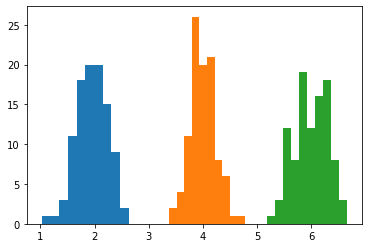

In [199]:
plt.hist(cluster1)
plt.hist(cluster2)
plt.hist(cluster3)

In [200]:
import scipy

def normalised_laplacian(S,style="rw"):
    w = S.sum(axis=1)
    D = np.diag(1.0/w)
    
    if style=="rw":
        return  D.dot(S)
    if style=="sym":
        D = np.diag(1.0/np.sqrt(w))
        return D.dot(S).dot(D)

def get_eigen(laplacian):
    eigen_val,eigen_vec = scipy.sparse.linalg.eigs(laplacian,10)
    return eigen_val,eigen_vec


### Eigengap in visibly seperate clusters

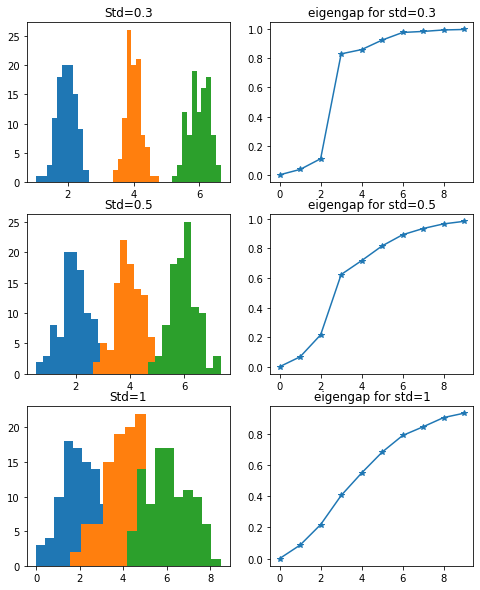

In [201]:
# for cluster in clusters[0]:
#     plt.hist(cluster)
    
    
fig,ax = plt.subplots(3,2,figsize=(8,10))


for i in range(3):
    for cluster in clusters[3-i-1]:
        ax[i][0].hist(cluster)
    ax[i][0].set_title("Std={std}".format(std=std[3-i-1]))
    
for j in range(2,-1,-1):
    c = data[j].reshape(-1,1)
    S = rbf_kernel(c,c)
    L = normalised_laplacian(S)
    e_val,e_vec = get_eigen(L)
    ax[3-j-1][1].plot(1-e_val.real,marker="*")
    ax[3-j-1][1].set_title("eigengap for std={}".format(std[j]))


fig.savefig("spec_gap.png")

### Cluster-3

In [202]:
cluster3 = data[2].reshape(-1,1)
S = rbf_kernel(cluster3,cluster3)
L = normalised_laplacian(S)
e_val,e_vec = get_eigen(L)



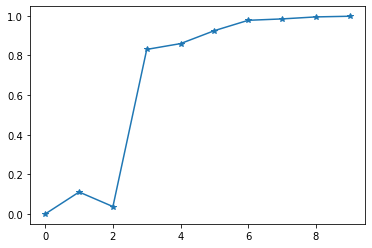

In [203]:
plt.plot(1-e_val.real,marker="*")

Cluster-3 shows eigengap

## Cluster-2 

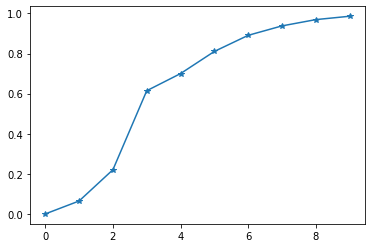

In [204]:
cluster2 = data[1].reshape(-1,1)
S = rbf_kernel(c2,c2)
L = normalised_laplacian(S)
e_val,e_vec = get_eigen(L)

plt.plot(1-e_val.real,marker="*")


we can see the eigengap 

### Cluster-1

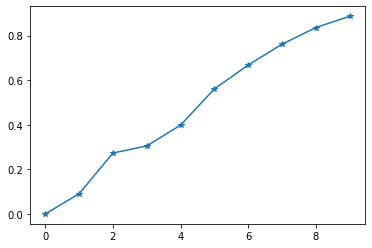

In [205]:
cluster1 = data[0].reshape(-1,1)
S = rbf_kernel(c1,c1)
L = normalised_laplacian(S)
e_val,e_vec = get_eigen(L)

plt.plot(1-e_val.real,marker="*")

The gap is difficult to observe, indicating the clusters aren't well defined which is accurate. 


## Eigengap for encoder without calculating eigenvalues

In [208]:
embeds = model.get_embedding()
embeds.shape

(178, 64)

In [209]:
args = {
    "dataset": "wine",
    "layers":[128,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch": 200,
    "device":"gpu"
}


In [210]:
def train_SAE(data,epochs=1000,rho=0.5,beta=0.01,lr=0.01,layer=[128,64,128]):
    
    X = torch.from_numpy(data)
    
    S = rbf_kernel(X,X,gamma=2)
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
   
    layers = [len(X_train)] + layer + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    
    optimizer  = optim.Adam(model.parameters(),lr=lr)
    
    with tqdm(total= epochs) as tq:
        for epoch in range(1,epochs +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
  
            
            loss = model.loss(X_hat,X_train,beta,rho)
            #nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
#             tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model, X_train.detach().cpu().numpy()


In [211]:
model,Q = train_SAE(cluster3.reshape(-1,1))

100%|██████████| 1000/1000 [00:02<00:00, 399.64it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]


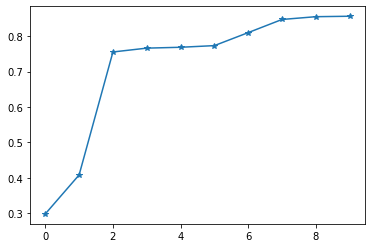

In [170]:
embed = model.get_embedding()
temp = np.matmul(Q,embed)
temp2 = temp/embed
evs = scipy.stats.trim_mean(temp2,0.1,axis=0)
s_evs = sorted(evs)
# s_evs = np.delete(s_evs,np.where(s_evs==0.3))
plt.plot(s_evs[:10],marker="*")

  4%|▍         | 40/1000 [00:00<00:02, 393.52it/s]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


  4%|▍         | 40/1000 [00:00<00:02, 394.67it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


100%|██████████| 1000/1000 [00:02<00:00, 388.86it/s]


[1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 2 1 0 0 1 1 1 1 2 2 0 2 1 1 2 1 2 0 1
 1 2 1 0 1 1 2 1 1 1 2 2 2 2 1 1 1 0 2 1 1 1 1 1 1 0 0 1 1 1 1 0 2 0 2 2 0
 1 2 0 0 2 2 1 1 1 1 1 2 1 1 0 2 0 1 1 0 2 1 1 2 2 1 0 2 1 1 2 2 2 0 1 1 2
 2 0 2 1]


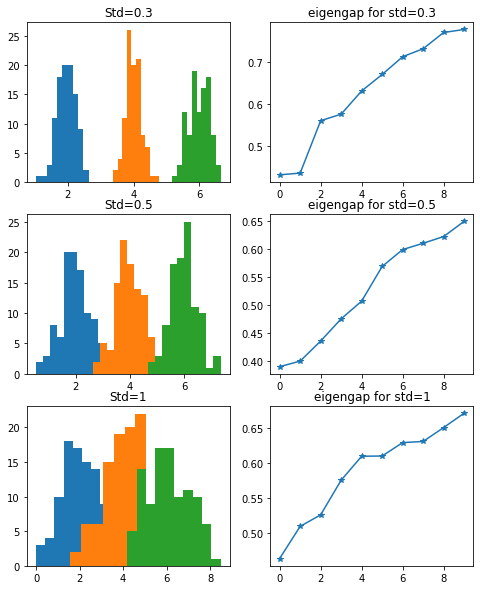

In [214]:
fig,ax = plt.subplots(3,2,figsize=(8,10))


for i in range(3):
    for cluster in clusters[3-i-1]:
        ax[i][0].hist(cluster)
    ax[i][0].set_title("Std={std}".format(std=std[3-i-1]))
    
clus= [cluster3,cluster2,cluster1]

for i,cluster in enumerate(clus):
    cluster = cluster.reshape(-1,1)
    model,Q = train_SAE(cluster)
    embed = model.get_embedding()
    temp = np.matmul(Q,embed)
    temp2 = temp/embed
    evs = scipy.stats.trim_mean(temp2,0.1,axis=0)
    s_evs = sorted(evs)
    # s_evs = np.delete(s_evs,np.where(s_evs==0.3))
    ax[i][1].plot(s_evs[:10],marker="*")
    ax[i][1].set_title("eigengap for std={}".format(std[3-i-1]))
fig.savefig("gapauto.png")    

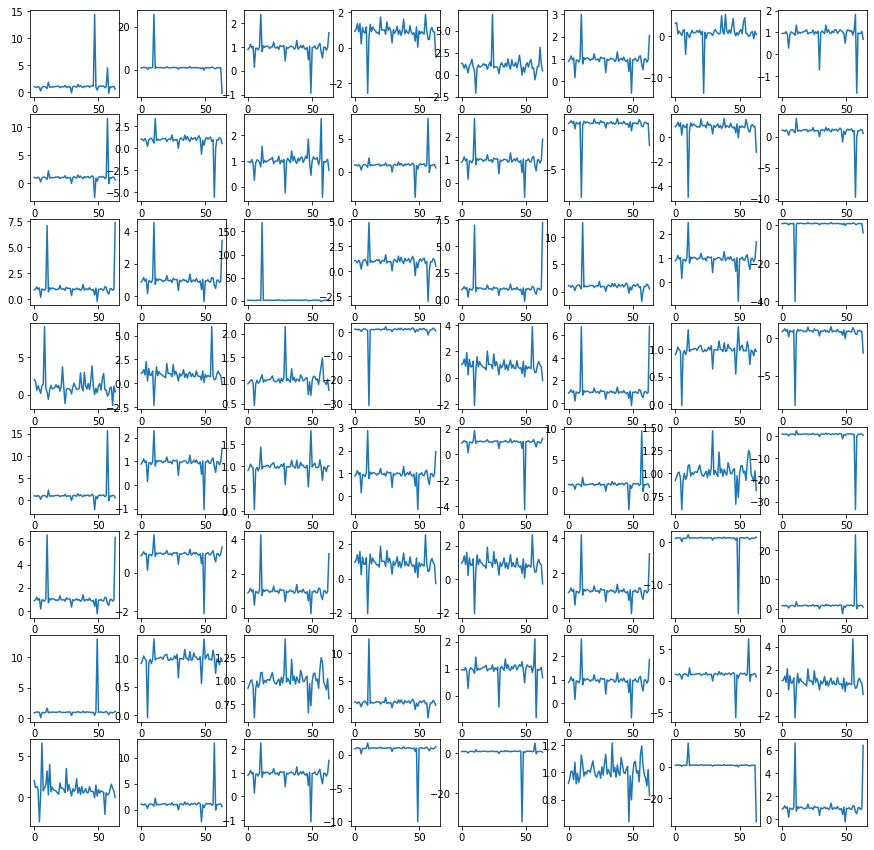

In [41]:
fig,ax = plt.subplots(8,8, figsize=(15,15))
for i in range(8):
    for j in range(8):
        ax[i][j].plot(temp2[:][8*i+j])

## Using a new dataset- 20 newsgroup

In [45]:
bunch = sklearn.datasets.fetch_20newsgroups_vectorized(subset="train", remove=(), data_home="data", download_if_missing=True)

In [48]:
data = bunch["data"]
dataD = data.todense()
y = bunch["target"]

In [47]:
S = rbf_kernel(dataD,dataD,gamma=2)

In [49]:
args = {
    "dataset": "wine",
    "layers":[128,64,32,64,128],
    "beta": 0.01,
    "rho":0.5,
    "lr": 0.01,
    "epoch": 200,
    "device":"gpu"
}

device = torch.device("cuda" if args["device"] == "gpu" else "cpu")

                      
def StackedAuto():
    #X,y = sklearn.datasets.load_iris(return_X_y=True, as_frame=False)
#     bunch = sklearn.datasets.fetch_20newsgroups_vectorized(subset="train", remove=(), data_home="data", download_if_missing=True)
#     X = bunch["data"].todense()
#     y = bunch["target"]
    k = len(np.unique(y))
    
    min_max_scaler = preprocessing.MinMaxScaler()
   # X = min_max_scaler.fit_transform(X)
    
    #S = rbf_kernel(X,X,gamma=0.1)
    
    #S = cosine_similarity(X,X)
    #S = sklearn.neighbors.kneighbors_graph(X,45, mode='connectivity').toarray()
    D  = np.diag(1.0/S.sum(axis=1))
    
    X_train = torch.tensor(D.dot(S)).float().to(device)
    
    layers = [len(X_train)] + args["layers"] + [len(X_train)]
    
    model = GraphEncoder(layers,k).to(device)
    optimizer  = optim.Adam(model.parameters(),lr=args["lr"])
    
    with tqdm(total= args["epoch"]) as tq:
        for epoch in range(1,args["epoch"] +1):
            optimizer.zero_grad()
            X_hat = model(X_train)
            loss = model.loss(X_hat,X_train, args["beta"],args["rho"])
            nmi = normalized_mutual_info_score(model.get_cluster(),y,average_method="arithmetic")
            loss.backward()
            optimizer.step()
            
            tq.set_postfix(loss=loss,nmi ="{:.3f}".format(nmi))
            tq.update()
        print(model.get_cluster())
    return model

model = StackedAuto()

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (64) must match the size of tensor b (11314) at non-singleton dimension 1